In [ ]:
# Date: 7.12.2023
# Author: Antti Kiviaho
#
# Notebook for associating survival and progression with the Club-region signature

In [1]:
import os 
os.chdir('/lustre/scratch/kiviaho/prostate_spatial/')

import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad

from scripts.utils import load_from_pickle, save_to_pickle
import matplotlib.pyplot as plt
import matplotlib as mpl

from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
from lifelines.statistics import logrank_test

import gseapy as gp
#import GSVA

import seaborn as sns
sns.set_theme(style='white')


import warnings
warnings.filterwarnings("ignore")



Matplotlib created a temporary config/cache directory at /tmp/matplotlib-dcufbo8u because the default path (/run/cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
def plot_distribution(df,score_name, thr = 0.5):

    data = df[score_name]
    # Create a figure and axes
    fig, ax = plt.subplots(figsize=(8,5))

    # Plot the histogram with blue bars for values smaller than the median and orange bars for values larger than the median
    n, bins, patches = ax.hist(data, bins=30)

    # Add a vertical line at the median
    ax.axvline(x=data.quantile(thr), color='black', linestyle='--')

    # Set labels and title
    ax.set_xlabel('Enrichment score')
    ax.set_ylabel('Frequency')
    ax.set_title(score_name + ' signature score distribution')

    # Show the plot
    plt.show()


def plot_kaplan_meier(df_original, score, measure, event, thr = 0.5, save_plot = True,show_plot=False,save_path='plots/kaplan_meier_curves/TCGA/'):
    
    quantile_value = df_original[score].quantile(thr)
    # Split the dataframe into two groups based on the score
    low_score_group = df_original[df_original[score] < quantile_value].copy()
    high_score_group = df_original[df_original[score] >= quantile_value].copy()
    print('High median: {:.2f}, low median: {:.2f}'.format(high_score_group[score].median(),low_score_group[score].median()))

    # Plot the Kaplan-Meier curves for each group
    fig, ax = plt.subplots(figsize=(12,8))

    # Fit the survival data to the Kaplan-Meier estimator for each group
    kmf1 = KaplanMeierFitter().fit(low_score_group[measure], event_observed=low_score_group[event], label=score + ' low')
    kmf2 = KaplanMeierFitter().fit(high_score_group[measure], event_observed=high_score_group[event], label=score + ' high')


    kmf1.plot(ax=ax, show_censors=True, ci_show=False,color='#1F77B4')
    kmf2.plot(ax=ax, show_censors=True, ci_show=False, color='#FF7F0E')
    
    ax.set_xlim(0,120)

    # Add labels and title to the plot
    plt.xlabel('Time (months)')
    plt.ylabel('Progression Free Interval (PFI)')



    results = logrank_test(high_score_group[measure], low_score_group[measure], event_observed_A=high_score_group[event], event_observed_B=low_score_group[event])

    # Print the p-value and test statistic
    print("Log-Rank Test p-value: {:.4f}".format(results.p_value))
    print("Log-Rank Test statistic: {:.1f}".format(results.test_statistic))
    print('')

    plt.title(score + ' GSVA score split by q=' + str(thr) + '\n two-sided log-rank p-value: {:.2e}'.format(results.p_value))

    # Add legend to the plot
    plt.legend()

    # Add 'at risk' counts table to the plot
    add_at_risk_counts(kmf1, kmf2)

    ax.set_ylim(-0.05,1.05)
    plt.tight_layout()

    if save_plot:
        plt.savefig(save_path + score.replace(' ','_') + '_kaplan_meier.pdf')

    if show_plot:
        
        # Display the plot
        plt.show()
    else:
        plt.clf()


def check_top_markers(r,p_thresh=0.05):
    # These results rank the deg significance and specificity (low p-value = good marker)
    deg_fishers_res_dict = load_from_pickle('./data/region_gene_markers_fishers_exact_test_240128.pkl')

    fishers_test_df = deg_fishers_res_dict[r].rename(columns={'interaction':'gene','active_in':'deg in'})
    fishers_test_df = fishers_test_df.sort_values('adj_pval').reset_index(drop=True)
    fishers_test_df = fishers_test_df[fishers_test_df['adj_pval'] < p_thresh]

    return fishers_test_df

def check_gene_marker_status(gene):
    # These results rank the deg significance and specificity (low p-value = good marker)
    deg_fishers_res_dict = load_from_pickle('./data/region_gene_markers_fishers_exact_test_240128.pkl')

    for r in deg_fishers_res_dict:
        fishers_test_df = deg_fishers_res_dict[r].rename(columns={'interaction':'gene','active_in':'deg in'})
        fishers_test_df = fishers_test_df.sort_values('adj_pval').reset_index(drop=True)
        if fishers_test_df['gene'].str.contains(gene).any(): 
            print(fishers_test_df[fishers_test_df['gene']==gene])
            print('')

### Dowloading and formatting the gene lists

In [3]:
gene_set_df = pd.read_excel('custom_gene_lists.xlsx',header=None).drop(columns=0).set_index(1).T

gene_sets_of_interest = gene_set_df.columns.tolist()

gene_sets = gene_set_df[gene_sets_of_interest].to_dict('list')

for key, value in gene_sets.items():
    # Remove NaN values from the list
    gene_sets[key] = [x for x in value if pd.notnull(x)]

In [4]:

gene_modules_dict = {
    'Tumor region': check_top_markers('Tumor')['gene'].tolist(),
    'Luminal region': check_top_markers('Luminal epithelium')['gene'].tolist(),
    'Basal region': check_top_markers('Basal epithelium')['gene'].tolist(),
    'Club region': check_top_markers('Club epithelium')['gene'].tolist(),
    'Immune region': check_top_markers('Immune')['gene'].tolist()
                    }

""" 
n_top = 100

for k in gene_modules_dict.keys():
    if len(gene_modules_dict[k]) > n_top:
        gene_modules_dict[k] = gene_modules_dict[k][:n_top]

 """
gene_modules_dict = {**gene_modules_dict,**gene_sets}
gene_modules_dict['Club_prosgenesis'] = list(np.intersect1d(gene_modules_dict['PROSGenesis'],gene_modules_dict['Club region']))
gene_modules_dict['Club_SCL'] = list(np.intersect1d(gene_modules_dict['CRPC-SCL'],gene_modules_dict['Club region']))
gene_modules_dict['Club_region_excl_club'] = list(set(gene_modules_dict['Club region']) - set(gene_modules_dict['Club']))
gene_modules_dict['Club_senescence_overlap'] = list(set(gene_modules_dict['Club region']).intersection(set(gene_modules_dict['MP19 Epithelial Senescence'])))


df = pd.DataFrame.from_dict(gene_modules_dict,orient='index').reset_index(names='name')
df = df.melt(id_vars='name').sort_values('name').dropna().reset_index(drop=True)
df.columns = ['name','description','member']
df['description'] = 'NA'
gmt_format_df = df.copy()

## TCGA-PRAD

In [5]:
# This is the old version of formatting the data

""" 
tcga_sample_sheet = pd.read_csv('bulk_RNAseq/TCGA_PRAD/gdc_sample_sheet.2023-12-07.tsv',sep='\t').set_index('Case ID')

tcga_patient_annot = pd.read_csv('bulk_RNAseq/TCGA_PRAD/TCGA_patient_annotations.csv',index_col=0).set_index('patient_barcode')
tcga_patient_annot = tcga_patient_annot[tcga_patient_annot['type'] == 'PRAD']

tcga_metadata = pd.merge(tcga_sample_sheet,tcga_patient_annot,left_index=True,right_index=True,how='left')
tcga_metadata['PFI'].value_counts()

 """

# This is downloaded from the Xena browser
# https://xenabrowser.net/datapages/?dataset=survival%2FPRAD_survival.txt&host=https%3A%2F%2Ftcga.xenahubs.net&removeHub=https%3A%2F%2Fxena.treehouse.gi.ucsc.edu%3A443
tcga_metadata = pd.read_csv('bulk_RNAseq/TCGA_PRAD/tcga_xenahubs_metadata.txt',sep='\t')
tcga_metadata['PFI'].value_counts()


0    470
1     96
Name: PFI, dtype: int64

In [6]:
""" 
# Extract TPM counts from the TCGA files
count_type = 'tpm_unstranded'
tcga_df_list = []

for idx in np.arange(len(tcga_metadata)):
    dir = tcga_metadata['File ID'].iloc[idx]
    file_name = tcga_metadata['File Name'].iloc[idx]
    sample = tcga_metadata['Sample ID'].iloc[idx]

    path = 'bulk_RNAseq/TCGA_PRAD/sequencing_reads/'+dir+'/'+file_name

    dat = pd.read_csv(path,sep='\t',index_col=None,skiprows=1)
    dat = dat.drop(index=[0,1,2,3])
    dat = dat[dat['gene_type'] == 'protein_coding'].reset_index(drop=True)
    dat = dat[['gene_name',count_type]].set_index('gene_name')
    dat.columns = [sample]

    tcga_df_list.append(dat)

    if idx %50 ==0:
        print(str(idx)+'/'+str(len(tcga_metadata)))

tcga_counts_dat = pd.concat(tcga_df_list,axis=1)

# Save the counts into a csv file
tcga_counts_dat.to_csv('data/tcga_tpm_counts.csv')

 """

# This is an expression dataframe downloaded formatted with the above code
#tcga_counts_dat = pd.read_csv('data/tcga_tpm_counts.csv')

# This is downloaded from the xena browser


tcga_counts_dat = pd.read_csv('bulk_RNAseq/TCGA_PRAD/TCGA_PRAD_xenabrowser_counts_2FHiSeqV2.txt',sep='\t')
tcga_counts_dat = tcga_counts_dat.rename(columns={'sample':'gene_name'})

In [ ]:
#  Run enrichment using the gseapy gsva method

tcga_enrich_res = gp.gsva(data=tcga_counts_dat,gene_sets=gene_modules_dict,outdir=None, min_size=0, max_size=2000)
tcga_enrich_df = tcga_enrich_res.res2d.pivot(index='Name', columns='Term', values='ES').reset_index(names='Sample Identifier')


final_tcga_data = pd.merge(tcga_enrich_df,tcga_metadata,left_on='Sample Identifier',right_on='sample').set_index('Sample Identifier')

# Transform days to months 
for col in final_tcga_data.columns:
    if '.time' in col:
        final_tcga_data[col] = final_tcga_data[col] / 30        



### Investigate signature correlations

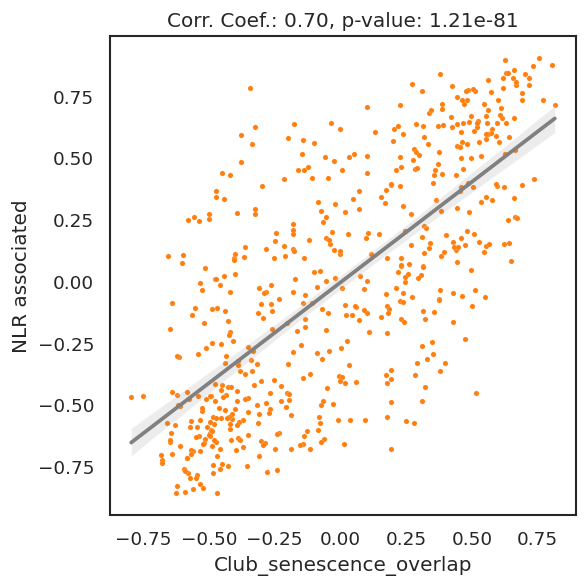

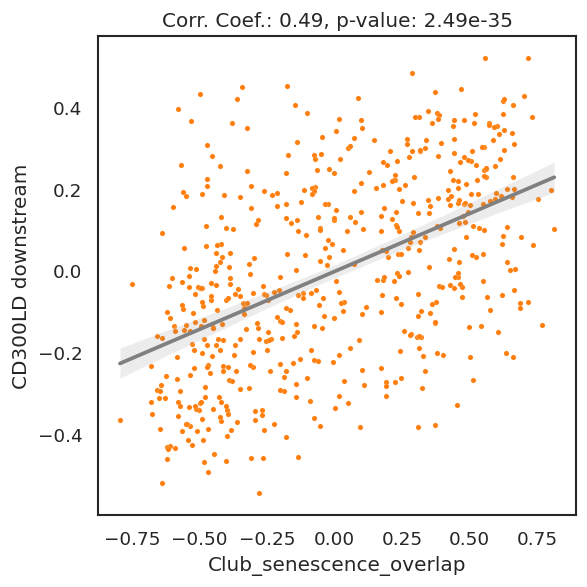

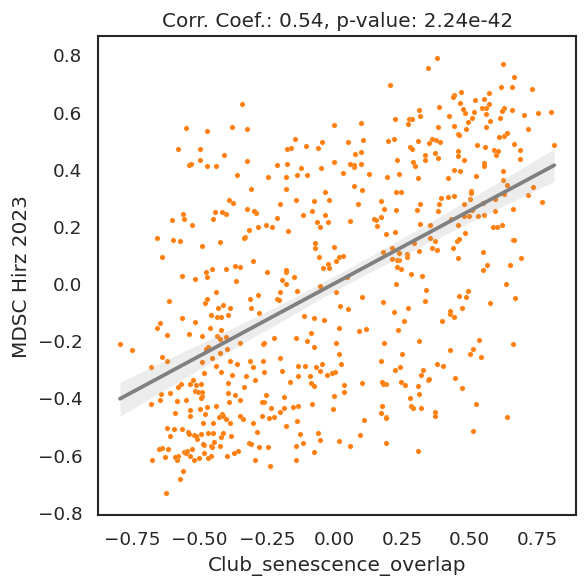

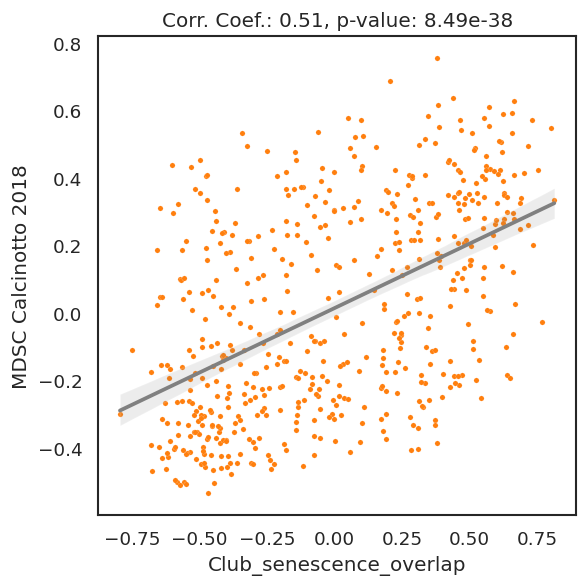

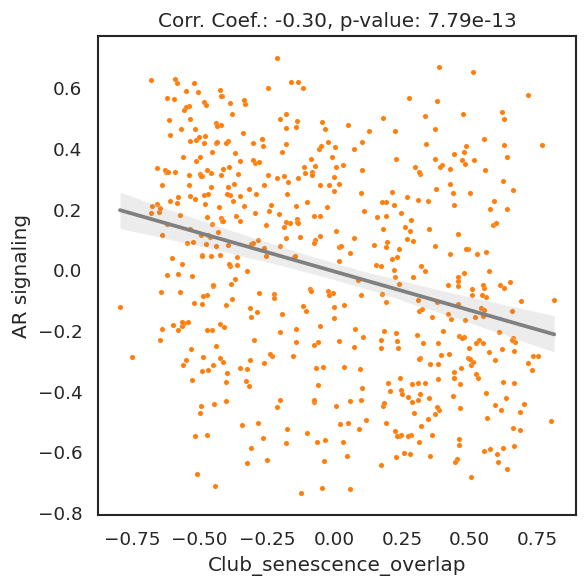

In [7]:
from scipy.stats import spearmanr

signature1 = 'Club_senescence_overlap'#'Club region'#'MP19 Epithelial Senescence'
signature2s = ['NLR associated','CD300LD downstream','MDSC Hirz 2023','MDSC Calcinotto 2018','AR signaling']

simple_gene_modules_dict = {
    signature1: gene_modules_dict[signature1]
}

for signature2 in signature2s:

    simple_gene_modules_dict[signature2] = set(gene_modules_dict[signature2]).difference(gene_modules_dict[signature1]) # Only remove the overlap from one gene set


# Run scoring
gsva_res = gp.gsva(data=tcga_counts_dat,gene_sets=simple_gene_modules_dict,outdir=None,min_size=0)
gsva_res_df = gsva_res.res2d.pivot(index='Name', columns='Term', values='ES').reset_index(names='Sample Identifier')

# Convert to float
gsva_res_df[signature1] = gsva_res_df[signature1].astype(float)

for signature2 in signature2s:

    # Convert to float
    gsva_res_df[signature2] = gsva_res_df[signature2].astype(float)

    ## PLOT ##
    fig, ax = plt.subplots(figsize=(5,5),dpi=120)
    # create scatterplot with color-coded points
    sns.scatterplot(x=signature1, y=signature2, data=gsva_res_df, linewidth=0.1, s=10, ax=ax,legend=False,color='#ff7f0e') # 

    # add regression line to plot
    sns.regplot(x=signature1, y=signature2, data=gsva_res_df, scatter=False, ax=ax,color='gray')

    #ax.set_ylim(-0.5,1.0)
    #ax.set_xlim(0,1.2)
    corr_coef, p_value = spearmanr(gsva_res_df[signature1], gsva_res_df[signature2])


    ax.set_title(f"Corr. Coef.: {corr_coef:.2f}, p-value: {p_value:.2e}")
    plt.tight_layout()

    plt.savefig('plots/score_correlations/TCGA_'+signature1.replace(' ','_')+signature2.replace(' ','_')+'_signature_correlation_in_bulk_no_overlap.pdf')
    plt.show()
    #plt.clf()

### Plot Kaplan-Meiers

In [ ]:
q = 0.5
score_name = 'Club_senescence_overlap'
plot_kaplan_meier(final_tcga_data, score_name, 'PFI.time', 'PFI',thr=q,save_plot=False,show_plot=True)

In [ ]:
q = 0.5

for score_name in gene_modules_dict.keys():
    if score_name in final_tcga_data.columns:
        print(score_name)
        #plot_distribution(final_tcga_data,score_name,thr=q)
        plot_kaplan_meier(final_tcga_data, score_name, 'PFI.time', 'PFI',thr=q)

## SU2C Metastatic Prostate Adenocarcinoma (SU2C/PCF Dream Team, PNAS 2019)

In [ ]:

def plot_kaplan_meier_SU2C(df_original, score, measure, event, thr = 0.5, save_plot = True,show_plot=False,save_path='plots/kaplan_meier_curves/SU2C/'):
      
    
    quantile_value = df_original[score].quantile(thr)
    # Split the dataframe into two groups based on the score
    low_score_group = df_original[df_original[score] < quantile_value].copy()
    high_score_group = df_original[df_original[score] >= quantile_value].copy()
    print('High median: {:.2f}, low median: {:.2f}'.format(high_score_group[score].median(),low_score_group[score].median()))

    # Plot the Kaplan-Meier curves for each group
    fig, ax = plt.subplots(figsize=(12,8))

    # Fit the survival data to the Kaplan-Meier estimator for each group
    kmf1 = KaplanMeierFitter().fit(low_score_group[measure], event_observed=low_score_group[event], label=score + ' low')
    kmf2 = KaplanMeierFitter().fit(high_score_group[measure], event_observed=high_score_group[event], label=score + ' high')


    kmf1.plot(ax=ax, show_censors=True, ci_show=False,color='#1F77B4')
    kmf2.plot(ax=ax, show_censors=True, ci_show=False, color='#FF7F0E')

    # Add labels and title to the plot
    plt.xlabel('Time (months)')
    plt.ylabel('Overall survival')



    results = logrank_test(high_score_group[measure], low_score_group[measure], event_observed_A=high_score_group[event], event_observed_B=low_score_group[event])

    # Print the p-value and test statistic
    print("Log-Rank Test p-value: {:.4f}".format(results.p_value))
    print("Log-Rank Test statistic: {:.1f}".format(results.test_statistic))
    print('')

    plt.title(score + ' GSVA score split by q=' + str(thr) + '\n two-sided log-rank p-value: {:.2e}'.format(results.p_value))

    # Add legend to the plot
    plt.legend()

    # Add 'at risk' counts table to the plot
    add_at_risk_counts(kmf1, kmf2)

    ax.set_ylim(-0.05,1.05)
    plt.tight_layout()

    if save_plot:
        plt.savefig(save_path + score.replace(' ','_') + '_kaplan_meier.pdf')

    if show_plot:
        
        # Display the plot
        plt.show()
    else:
        plt.clf()


In [ ]:
# Download both subsets
dat_polya = pd.read_csv('bulk_RNAseq/prad_su2c_2019/data_mrna_seq_fpkm_polya_zscores_ref_all_samples.txt',sep='\t',index_col=0)
dat_capture = pd.read_csv('bulk_RNAseq/prad_su2c_2019/data_mrna_seq_fpkm_capture_zscores_ref_all_samples.txt',sep='\t',index_col=0)

su2c_clinical_data = pd.read_csv('bulk_RNAseq/prad_su2c_2019/prad_su2c_2019_clinical_data.tsv',sep='\t')
#su2c_clinical_data = su2c_clinical_data[(su2c_clinical_data['Abiraterone (ABI) and Enzalutamide (ENZA) Exposure Status']=='Naive') & ~(su2c_clinical_data['Overall Survival Status'].isna())].reset_index(drop=True)

# Drop those the entries that don't have survival status information
su2c_clinical_data = su2c_clinical_data[~(su2c_clinical_data['Overall Survival Status'].isna())].reset_index(drop=True)

# Format OS into float for the Kaplan Meier plotting
su2c_clinical_data['OS'] = pd.Series([s[0] for s in su2c_clinical_data['Overall Survival Status'].str.split(':')],dtype=float)

su2c_clinical_data['Overall Survival Status'].value_counts()

### Score correlations

2024-02-21 15:28:08,919 [WARNING] Input data contains NA, filled NA with 0
2024-02-21 15:28:08,955 [WARNING] Found duplicated gene names, values averaged by gene names!


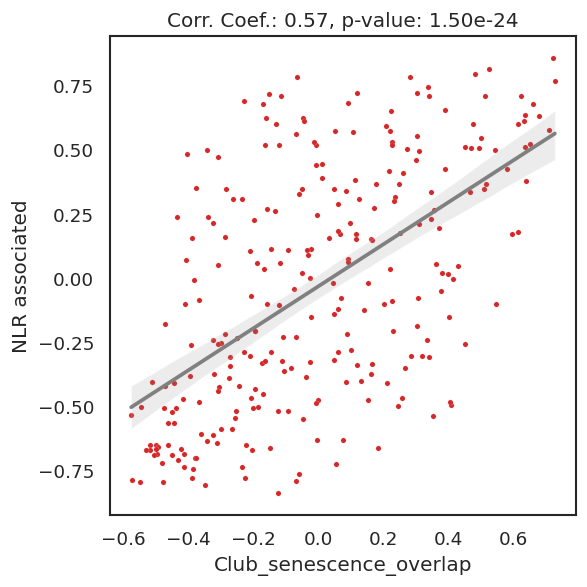

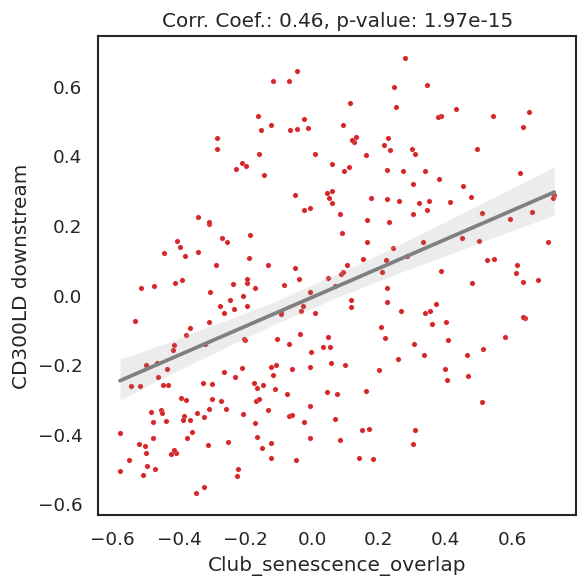

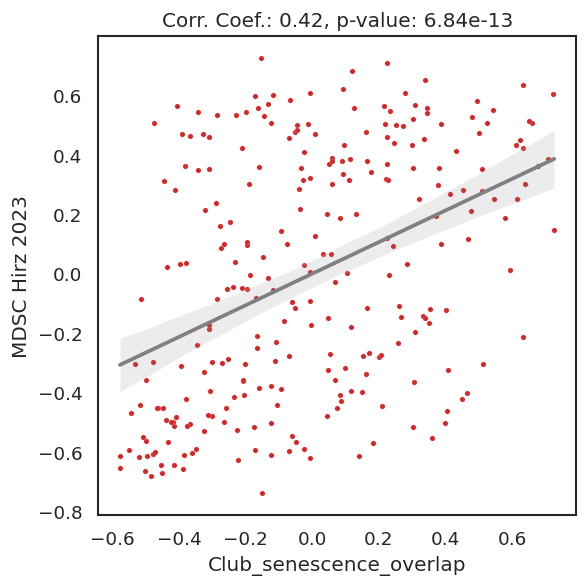

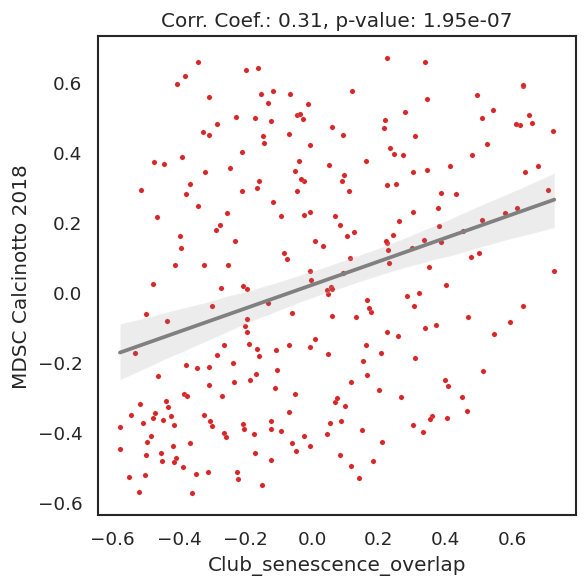

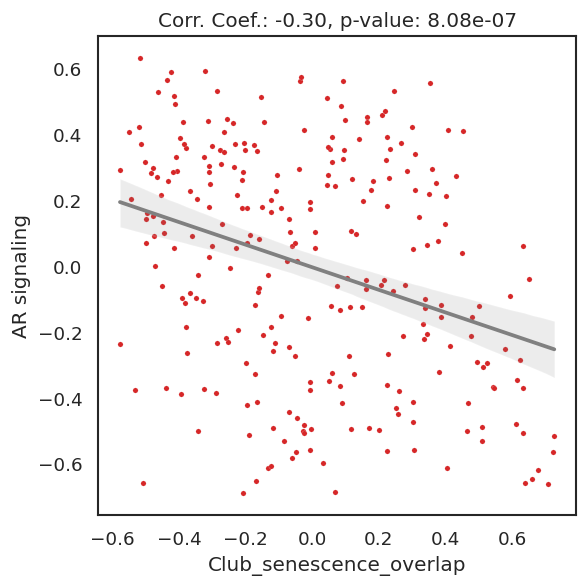

In [16]:
from scipy.stats import spearmanr

signature1 = 'Club_senescence_overlap'#'Club region'#'MP19 Epithelial Senescence'
signature2s = ['NLR associated','CD300LD downstream','MDSC Hirz 2023','MDSC Calcinotto 2018','AR signaling']

simple_gene_modules_dict = {
    signature1: gene_modules_dict[signature1]
}

for signature2 in signature2s:

    simple_gene_modules_dict[signature2] = set(gene_modules_dict[signature2]).difference(gene_modules_dict[signature1]) # Only remove the overlap from one gene set


# Run scoring
gsva_res = gp.gsva(data=dat_polya,gene_sets=simple_gene_modules_dict,outdir=None,min_size=0)
gsva_res_df = gsva_res.res2d.pivot(index='Name', columns='Term', values='ES').reset_index(names='Sample Identifier')

# Convert to float
gsva_res_df[signature1] = gsva_res_df[signature1].astype(float)

for signature2 in signature2s:

    # Convert to float
    gsva_res_df[signature2] = gsva_res_df[signature2].astype(float)

    ## PLOT ##
    fig, ax = plt.subplots(figsize=(5,5),dpi=120)
    # create scatterplot with color-coded points
    sns.scatterplot(x=signature1, y=signature2, data=gsva_res_df, linewidth=0.1, s=10, ax=ax,legend=False,color='#d62728') # 

    # add regression line to plot
    sns.regplot(x=signature1, y=signature2, data=gsva_res_df, scatter=False, ax=ax,color='gray')

    #ax.set_ylim(-0.5,1.0)
    #ax.set_xlim(0,1.2)
    corr_coef, p_value = spearmanr(gsva_res_df[signature1], gsva_res_df[signature2])


    ax.set_title(f"Corr. Coef.: {corr_coef:.2f}, p-value: {p_value:.2e}")
    plt.tight_layout()

    plt.savefig('plots/score_correlations/SU2C_'+signature1.replace(' ','_')+signature2.replace(' ','_')+'_signature_correlation_in_bulk_no_overlap.pdf')
    plt.show()
    #plt.clf()

In [ ]:



signature1 = 'CD300LD downstream'#'AR signaling'
signature2 = 'Club_senescence_overlap'#'Club region'#'MP19 Epithelial Senescence'

simple_gene_modules_dict = {
    signature1: list(set(gene_modules_dict[signature1]).difference(gene_modules_dict[signature2])), # Only remove the overlap from one gene set
    signature2: gene_modules_dict[signature2] 
}


gsva_res = gp.gsva(data=dat_polya,gene_sets=simple_gene_modules_dict,outdir=None)
gsva_res_df = gsva_res.res2d.pivot(index='Name', columns='Term', values='ES').reset_index(names='Sample Identifier')

# Add a sample class identifier column

# Convert to float
for sig in [signature1,signature2]:
    gsva_res_df[sig] = gsva_res_df[sig].astype(float)


In [ ]:

## PLOT ##
fig, ax = plt.subplots(figsize=(5,5),dpi=120)
# create scatterplot with color-coded points
sns.scatterplot(x=signature1, y=signature2, data=gsva_res_df, linewidth=0.1, s=10, ax=ax,legend=False,color='#d62728') # 

# add regression line to plot
sns.regplot(x=signature1, y=signature2, data=gsva_res_df, scatter=False, ax=ax,color='gray')

#ax.set_ylim(-0.5,1.0)
#ax.set_xlim(0,1.2)
corr_coef, p_value = spearmanr(gsva_res_df[signature1], gsva_res_df[signature2])


ax.set_title(f"Corr. Coef.: {corr_coef:.2f}, p-value: {p_value:.2e}")
plt.tight_layout()

plt.savefig('plots/score_correlations/SU2C_'+signature1.replace(' ','_')+signature2.replace(' ','_')+'_signature_correlation_in_bulk_no_overlap.pdf')
plt.show()
#plt.clf()

### Run scoring

In [ ]:
# Run enrichment of both the the polyA and the capture sets

polya_enrichment_res = gp.gsva(data=dat_polya,gene_sets=gene_modules_dict,outdir=None, min_size=0, max_size=2000)
polya_enrichment_df = polya_enrichment_res.res2d.pivot(index='Name', columns='Term', values='ES').reset_index(names='Sample Identifier')

capture_enrichment_res = gp.gsva(data=dat_capture,gene_sets=gene_modules_dict,outdir=None, min_size=0, max_size=2000)
capture_enrichment_df = capture_enrichment_res.res2d.pivot(index='Name', columns='Term', values='ES').reset_index(names='Sample Identifier')

In [ ]:
# Merge enrichment results with the metadata
polya_enrichment_res = pd.merge(su2c_clinical_data,polya_enrichment_df,left_on='Sample ID',right_on='Sample Identifier')
capture_enrichment_res = pd.merge(su2c_clinical_data,capture_enrichment_df,left_on='Sample ID',right_on='Sample Identifier')


### polyA samples Kaplan-Meiers

In [ ]:
q = 0.5

score_name = 'Club_senescence_overlap'

if score_name in polya_enrichment_res.columns:
    print(score_name)
    #plot_distribution(final_tcga_data,score_name,thr=q)
    plot_kaplan_meier_SU2C(polya_enrichment_res, score_name,measure = 'Overall Survival (Months)',event = 'OS',thr=q,save_plot=False,show_plot=True)

In [ ]:
q = 0.5

#for score_name in ['Club_senescence_overlap']:
for score_name in gene_modules_dict.keys():
    if score_name in polya_enrichment_res.columns:
        print(score_name)
        #plot_distribution(final_tcga_data,score_name,thr=q)
        plot_kaplan_meier_SU2C(polya_enrichment_res, score_name,measure = 'Overall Survival (Months)',event = 'OS',thr=q,save_plot=True,show_plot=False)

### Both datasets

In [ ]:

# Include only samples that don't have polya from the capture set
capture_enrichment_res_non_ovelap = capture_enrichment_res[~(capture_enrichment_res['Sample Identifier'].isin(polya_enrichment_res['Sample Identifier']))]

final_enrichment_dataset = pd.concat([polya_enrichment_res,capture_enrichment_res_non_ovelap],axis=0,ignore_index=True)

#final_enrichment_dataset = pd.concat([polya_enrichment_res,capture_enrichment_res],axis=0,ignore_index=True)

final_enrichment_dataset['OS'].value_counts()

### Plot Kaplan Meiers

In [ ]:
q = 0.5

score_name = 'Persist'

if score_name in final_enrichment_dataset.columns:
    print(score_name)
    #plot_distribution(final_tcga_data,score_name,thr=q)
    plot_kaplan_meier_SU2C(final_enrichment_dataset, score_name,measure = 'Overall Survival (Months)',event = 'OS',thr=q,save_plot=False,show_plot=True)

In [ ]:
q = 0.5

for score_name in gene_modules_dict.keys():
    if score_name in final_enrichment_dataset.columns:
        print(score_name)
        #plot_distribution(final_tcga_data,score_name,thr=q)
        plot_kaplan_meier_SU2C(final_enrichment_dataset, score_name,measure = 'Overall Survival (Months)',event = 'OS',thr=q,save_plot=True,show_plot=False)

In [ ]:
# Download clinical data (patient based)

# Format the dataframe
meta_patient = pd.read_csv('bulk_RNAseq/prad_su2c_2019/data_clinical_patient.txt',sep='\t')
meta_patient = meta_patient.drop(index=[0,1,2,3,4]).reset_index(drop=True)
meta_patient.columns = [s.strip('#') for s in meta_patient.columns]

# Discard patient for whom there is no OS data
meta_patient = meta_patient[~(meta_patient['Overall Survival Status'].isna())]
meta_patient['Overall Survival Status'].value_counts()

In [ ]:
# Download sample metadata

# Format the dataframe
meta_sample = pd.read_csv('bulk_RNAseq/prad_su2c_2019/data_clinical_sample.txt',sep='\t')
meta_sample = meta_sample.drop(index=[0,1,2,3,4]).reset_index(drop=True)
meta_sample.columns = [s.strip('#') for s in meta_sample.columns]

# Merge patient clinical and sample metadata
metadata = pd.merge(meta_sample[['Sample Identifier','Patient Identifier']],meta_patient,left_on='Patient Identifier',right_on='Patient Identifier',how='left')
metadata = metadata[~(metadata['Overall Survival Status'].isna())]